# Cumulative Deaths Logistic Function Model (for highly impacted counties)
### Utilizes nyt_us_counties_cumulative.csv in the /data/us/covid/ directory for cumulative deaths data.
### (An auxilary) model is used for lowly impacted counties.

In [1]:
import numpy as np
import pandas as pd
import git
import matplotlib.pyplot as plt
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

## Read in data file and process

In [2]:
cum_deaths_df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_cumulative.csv", converters={'fips' : str, 'date' : str})
print(cum_deaths_df.dtypes)
print('W/ Converters -> fips : ' + str(type(cum_deaths_df['fips'][0])) + ', date : ' + str(type(cum_deaths_df['date'][0])))

# We specify the data type of fips and date as str using a converter for preprocessing convenience's sake.

fips          object
date          object
county        object
state         object
cases          int64
deaths         int64
new_cases    float64
infected     float64
dtype: object
W/ Converters -> fips : <class 'str'>, date : <class 'str'>


### Note that this NYT dataset lists elements by unique date, county/fips pairs.

In [3]:
print('NYT dataset:')
print(cum_deaths_df.head())

NYT dataset:
    fips        date     county       state  cases  deaths  new_cases  \
0  53061  2020-01-21  Snohomish  Washington      1       0        1.0   
1  53061  2020-01-22  Snohomish  Washington      1       0        0.0   
2  53061  2020-01-23  Snohomish  Washington      1       0        0.0   
3  53061  2020-01-24  Snohomish  Washington      1       0        0.0   
4  53061  2020-01-25  Snohomish  Washington      1       0        0.0   

   infected  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


### Here is the number of counties in our dataset prior to adjusting for multi-county regions included as single entries in the dataset. 

In [4]:
print(str(len(set(list(cum_deaths_df['fips']))) - 1) + " counties total (without correcting for aggregation)")

# We subtract 1 here because this dataset includes a minority of data entries that do not have an exact fips code. These are 
# assigned a common FIPS code of 0 and correspond to the aforementioned multi-county regions.

2763 counties total (without correcting for aggregation)


### Now we'll construct an additional column called "day_rank" which will hold the number of days from some reference past date (reference date will be the same for all entries) to the entry's date. This will be used later to construct data compatible for fitting.

In [5]:
from datetime import date

# Returns a 3-tuple of the year, month, and day of the date "ds". Assumes ds is a string in form "year-month-day"
def date_from_str(ds):
    year = int(ds[:4])
    month = int(ds[5:7])
    day = int(ds[8:])
    return (year, month, day)

dates = np.array(cum_deaths_df['date'])
day_rank = []
date_benchmark = date(2018, 1, 1) # some arbitrary date long before COVID-19 was around

# compute all dates' day ranks
for i in range(len(dates)):
    year, month, day = date_from_str(dates[i])
    date_cur = date(year, month, day)
    day_rank.append((date_cur - date_benchmark).days)

cum_deaths_df['day_rank'] = np.array(day_rank)
cum_deaths_df.head()

,fips,date,county,state,cases,deaths,new_cases,infected,day_rank
0,53061,2020-01-21,Snohomish,Washington,1,0,1.0,NaN,750
1,53061,2020-01-22,Snohomish,Washington,1,0,0.0,NaN,751
2,53061,2020-01-23,Snohomish,Washington,1,0,0.0,NaN,752
3,53061,2020-01-24,Snohomish,Washington,1,0,0.0,NaN,753
4,53061,2020-01-25,Snohomish,Washington,1,0,0.0,NaN,754


### Let's check if any of the fips are invalid or missing.

In [6]:
all_clear = True
fips = list(cum_deaths_df['fips'])
for fip in fips:
    if ((not any([char.isdigit()] for char in fip)) or fip == ""):
        all_clear = False
        print('NaN or missing fips found.')
        
if all_clear: print('All fips are valid; none are invalid or missing.')

All fips are valid; none are invalid or missing.


### Let's look at some stats regarding the current distribution of cumulative deaths.

In [7]:
recent_deaths = list(cum_deaths_df[cum_deaths_df['date'] == '2020-04-20']['deaths'])

# Average cumulative deaths per county
print('Average: ' + str(sum(recent_deaths) / len(recent_deaths))[:2] + ' deaths')

# Standard deviation
print('Standard Deviation: ' + str(np.std(np.array(recent_deaths)))[:2] + ' deaths')

# Number of counties above deaths threshold
thresholds = [1, 5, 10, 20, 50, 100, 500, 1000, 5000]
for threshold in thresholds:
    count = 0
    for d in recent_deaths:
        if (d >= threshold):
            count += 1
    print(str(100 * count / len(recent_deaths))[:4] + "% of all counties have " + str(threshold) 
          + " or more cumulative deaths as of April 20th, 2020.")

# Max deaths county
idx_max = recent_deaths.index(max(recent_deaths))
print(str(cum_deaths_df['county'][idx_max]) + ' County (fips = ' + str(cum_deaths_df['fips'][idx_max]) + 
      ') has the maximum cumulative deaths, ' + str(max(recent_deaths)) + ' deaths')

Average: 13 deaths
Standard Deviation: 20 deaths
45.3% of all counties have 1 or more cumulative deaths as of April 20th, 2020.
17.5% of all counties have 5 or more cumulative deaths as of April 20th, 2020.
10.9% of all counties have 10 or more cumulative deaths as of April 20th, 2020.
6.72% of all counties have 20 or more cumulative deaths as of April 20th, 2020.
3.27% of all counties have 50 or more cumulative deaths as of April 20th, 2020.
1.81% of all counties have 100 or more cumulative deaths as of April 20th, 2020.
0.36% of all counties have 500 or more cumulative deaths as of April 20th, 2020.
0.10% of all counties have 1000 or more cumulative deaths as of April 20th, 2020.
0.03% of all counties have 5000 or more cumulative deaths as of April 20th, 2020.
Snohomish County (fips = 53061) has the maximum cumulative deaths, 10009 deaths


### We'll now construct data usable for fitting.

In [8]:
# class used to represent each county and its data required for modeling
class data_entry:
    def __init__(self, deaths=[], times=[]):
        self.deaths = deaths
        self.times = times

In [33]:
# map counties' fips to concatenated deaths and dates from our dataset's data entries
county_dict = {}
counties = np.array(cum_deaths_df['fips'])
deaths = np.array(cum_deaths_df['deaths'])
dates = np.array(cum_deaths_df['day_rank'])
unique_counties = set(counties)
for county in list(unique_counties):
    t = []
    d = []
    for i in range(len(deaths)):
        if counties[i] == county:
            t.append(dates[i])
            d.append(deaths[i])
    county_dict[county] = data_entry(deaths=d, times=t)

[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840]


In [34]:
print(county_dict['53061'].deaths)
count = 0
for fips in counties:
    if fips == '53061':
        count += 1
print(count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 4, 5, 6, 7, 9, 10, 10, 15, 15, 18, 23, 23, 23, 30, 32, 39, 39, 41, 44, 48, 57, 60, 61, 63, 66, 67, 69, 73, 77, 80, 85, 87, 92, 92, 96]
91


### We will now process and divide our mapping into four categories of severity with respect to selected cumulative death divisions based on April 20th, 2020.

In [119]:
# function to process and divide counties into usable data
def process_county(county, county_dict):
    # subsets of fit data for which we are constructing
    X_sub = []
    Y_sub = []
    
    # find first day where a death occured
    entry = county_dict[county]
    first_death = 0
    for i in range(len(entry.deaths)):
        if entry.deaths[i] == 1:
            first_death = i
            break
    
    # We map X_sub in this way in order to shift dates (in the form of day_rank values) so that first_death is rank 0
    X_sub = list(map(lambda x: x - entry.times[first_death], entry.times[first_death:]))
    Y_sub = list(entry.deaths[first_death:])
    return data_entry(Y_sub, X_sub)

# use process_county funtion to clean county_dict
counties = county_dict.keys()
for county in counties:
    county_dict[county] = process_county(county, county_dict)

# returns the division of the input deaths value
def find_div(d, divs):
    for i in range(len(divs) + 1):
        if i == 0:
            if 0 < d and d <= divs[i]:
                return 0
        if i != len(divs):
            if (divs[i - 1] < d and d <= divs[i]):
                return i
        if (i == len(divs) and d > divs[-1]):
            return i

In [124]:
# cumulative death divisions for categorizing each county
divisions = [30, 50, 300, 500]

# list of fit data for each division, each of which we will construct
divs_fitX = []
divs_fitY = []
for i in range(len(divisions) + 1):
    divs_fitX.append([])
    divs_fitY.append([])

# process county_dict into the 4 divisions of fit data
included_counties = [] # used to track which counties can use this modeling for prediction|
for county in county_dict:
    cum_deaths = list(county_dict[county].deaths)
    times = list(county_dict[county].times)
    if cum_deaths[-1] > 0:
        div = find_div(cum_deaths[-1], divisions)
        divs_fitX[div] += times
        divs_fitY[div] += cum_deaths
        included_counties.append(county)

### Now that we have our divisions set up, let's look at the cumulative deaths versus time curves for each of the four categories of counties. These curves are what we hope to fit to a logistic function to.

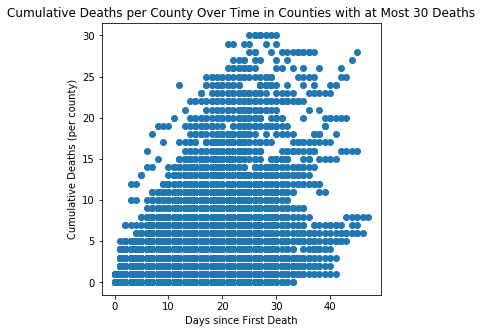

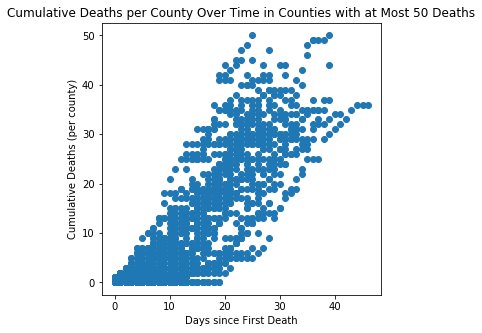

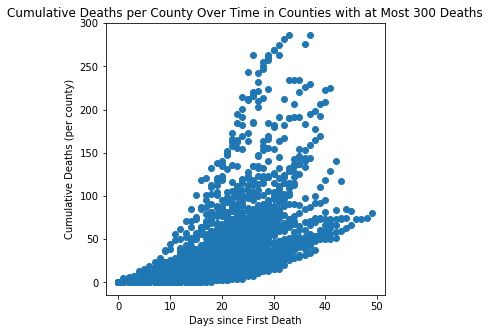

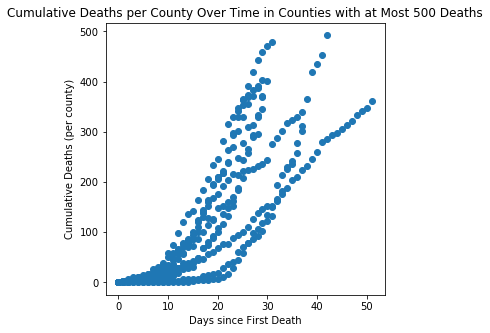

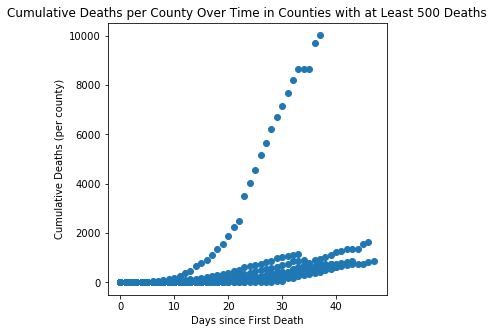

In [125]:
for i in range(len(divisions)):
    plt.figure(figsize=(5, 5))
    plt.scatter(divs_fitX[i], divs_fitY[i])
    plt.ylabel("Cumulative Deaths (per county)")
    plt.xlabel("Days since First Death")
    plt.title("Cumulative Deaths per County Over Time in Counties with at Most " + str(divisions[i]) + ' Deaths')
    plt.show()
plt.figure(figsize=(5, 5))
plt.scatter(divs_fitX[-1], divs_fitY[-1])
plt.ylabel("Cumulative Deaths (per county)")
plt.xlabel("Days since First Death")
plt.title("Cumulative Deaths per County Over Time in Counties with at Least " + str(divisions[-1]) + ' Deaths')
plt.show()

## Fitting and Predicting
### Now let's actually fit a logistic curve to each included county.